In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import shapiro, kstest, t, laplace, genextreme

In [6]:
# Define utility functions
def format_date_axis():
    """Formats the date axis with year and month."""
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)

def plot_cumulative_log_returns(data, cumsum_data, title, currencies=None):
    """Plots the cumulative log returns for given currencies."""
    plt.figure(figsize=(15, 10))
    if currencies is None:
        for column in cumsum_data.columns:
            plt.plot(data['Date'], cumsum_data[column], label=column)
    else:
        for currency in currencies:
            plt.plot(data['Date'], cumsum_data[currency], label=currency)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Log Returns')
    plt.title(title)
    format_date_axis()
    plt.legend()
    plt.tight_layout()
    plt.show()

def decompose_and_plot(data, currency, period=252):
    """Decomposes and plots time series data for a currency."""
    decomposition = seasonal_decompose(data[currency], model='additive', period=period)
    fig = decomposition.plot()
    fig.suptitle(f'Time Series Decomposition of {currency}', fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_rolling_volatility(data, currencies_group, window_size, group_number):
    """Plots rolling volatility for a set of currencies."""
    plt.figure(figsize=(15, 5))
    for currency in currencies_group:
        rolling_volatility = data[currency].rolling(window=window_size).std()
        plt.plot(data['Date'], rolling_volatility, label=f'Volatility of {currency}')
    plt.title(f'{window_size}-Day Rolling Volatility for Group {group_number}')
    plt.xlabel('Date')
    plt.ylabel('Rolling Volatility (Standard Deviation)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def fit_and_test_distribution(data, distribution, distribution_name):
    """Fits distribution and performs Kolmogorov-Smirnov test."""
    params = distribution.fit(data)
    ks_statistic, p_value = kstest(data, distribution_name, args=params)
    return ks_statistic, p_value, params

def plot_histograms_side_by_side(data, columns, bins):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))  # Increased figure width to accommodate the legend

    for axis, log_scale in zip(ax, [False, True]):
        for column in columns:
            axis.hist(data[column].dropna(), bins=bins, alpha=0.5, log=log_scale, label=column)
        axis.set_title('Distribution of Log Returns for 26 Currencies')
        axis.set_xlabel('Log Returns')
        axis.set_ylabel('Frequency (Log Scale)' if log_scale else 'Frequency')

    # Create a custom legend for the first subplot
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(columns)//2, bbox_to_anchor=(0.5, 1.05))
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_combined_histogram_side_by_side(data, bins):
    """Plots two histograms side by side for combined log returns, one with log scale and one without."""
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    
    counts, _ = np.histogram(data, bins=bins, density=False)
    max_frequency = np.max(counts)  # Calculate the maximum frequency

    for axis, log_scale in zip(ax, [False, True]):
        axis.hist(data, bins=bins, alpha=0.7, log=log_scale)
        axis.set_title('Distribution of Combined Log Returns for 26 Currencies')
        axis.set_xlabel('Log Returns')
        axis.set_ylabel('Frequency (Log Scale)' if log_scale else 'Frequency')

    plt.tight_layout()
    plt.show()

    return max_frequency  # Return the maximum frequency value

def fit_and_plot_distributions_side_by_side(data, distributions, distribution_names, bins, max_frequency):
    """Fits distributions, compiles results, and plots frequency histograms alongside fitted distributions."""
    fit_results = []

    # Generate the histogram data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Simplified calculation

    # Calculate the area under the histogram for scaling the PDF to frequencies
    area_under_histogram = np.sum(counts) * (bin_edges[1] - bin_edges[0])

    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    for axis in ax:
        axis.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]), alpha=0.3, label='Histogram')
        if axis is ax[1]:  # Check if this is the second plot
            axis.set_yscale('log')
            axis.set_ylim(1, max_frequency)

    for dist, name in zip(distributions, distribution_names):
        # Fit the distribution to the data
        params = dist.fit(data)
        # Scale the PDF by the area under the histogram
        scaled_pdf = dist.pdf(bin_centers, *params) * area_under_histogram

        for axis in ax:
            axis.plot(bin_centers, scaled_pdf, label=f'{name.capitalize()} Distribution')

        # Perform the KS test
        ks_statistic, p_value = stats.kstest(data, name, args=params)
        fit_results.append({
            "Distribution": name,
            "KS Statistic": ks_statistic,
            "P-Value": p_value,
            "Parameters": params
        })

    # Set common titles and labels
    common_title = 'Fitted Distributions of Combined Log Returns for 26 Currencies'
    common_ylabel = 'Frequency (Log Scale)' if ax[1].get_yscale() == 'log' else 'Frequency'
    
    for axis in ax:
        axis.set_title(common_title)
        axis.set_xlabel('Log Returns')
        axis.set_ylabel(common_ylabel)
        axis.legend()

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(fit_results)

In [7]:
# Read and process data
log_returns_data = pd.read_csv("Results/log_returns.csv")

# Descriptive Analysis

This will include the mean, median, standard deviation, minimum, maximum, and quartiles for each currency pair. This analysis provides a comprehensive overview of the central tendency, dispersion, and distribution shape of the log returns for each currency pair.

In [8]:
# Descriptive statistics
descriptive_stats = log_returns_data.describe()
descriptive_stats.drop(['count'], inplace=True)  # Dropping 'count' as it's the same for all
descriptive_stats.transpose()

,mean,std,min,25%,50%,75%,max
USDAUD,4.056712e-05,0.007999,-0.090007,-0.004196,-0.000244,0.004007,0.077604
USDEUR,4.358308e-05,0.007284,-0.159632,-0.003131,0.000040,0.003220,0.143324
USDGBP,9.654589e-05,0.006043,-0.034848,-0.003131,0.000078,0.003191,0.079085
USDJPY,6.755748e-05,0.007539,-0.168471,-0.003118,0.000218,0.003324,0.162885
USDNZD,1.026877e-05,0.007916,-0.053018,-0.004687,-0.000152,0.004352,0.067956
USDCAD,4.644509e-05,0.005593,-0.036946,-0.002875,0.000014,0.002976,0.035984
USDCHF,-6.272905e-05,0.006739,-0.176109,-0.003282,0.000140,0.003132,0.092355
USDCNY,1.379575e-06,0.002175,-0.014166,-0.000819,-0.000033,0.000706,0.015799
USDCZK,-6.361296e-07,0.007369,-0.051210,-0.003875,-0.000096,0.003815,0.038534
USDDKK,5.660596e-05,0.005705,-0.028983,-0.003192,-0.000013,0.003235,0.027897


# Correlation Analysis

This involves calculating the Pearson correlation coefficients between the log returns of different currency pairs. The correlation coefficient ranges from -1 to 1, where:

- 1 indicates a perfect positive correlation (as one currency pair increases, the other does as well).
- 0 indicates no correlation.
- -1 indicates a perfect negative correlation (as one currency pair increases, the other decreases).

This analysis will help us understand how the movements in different currency pairs are related to each other.

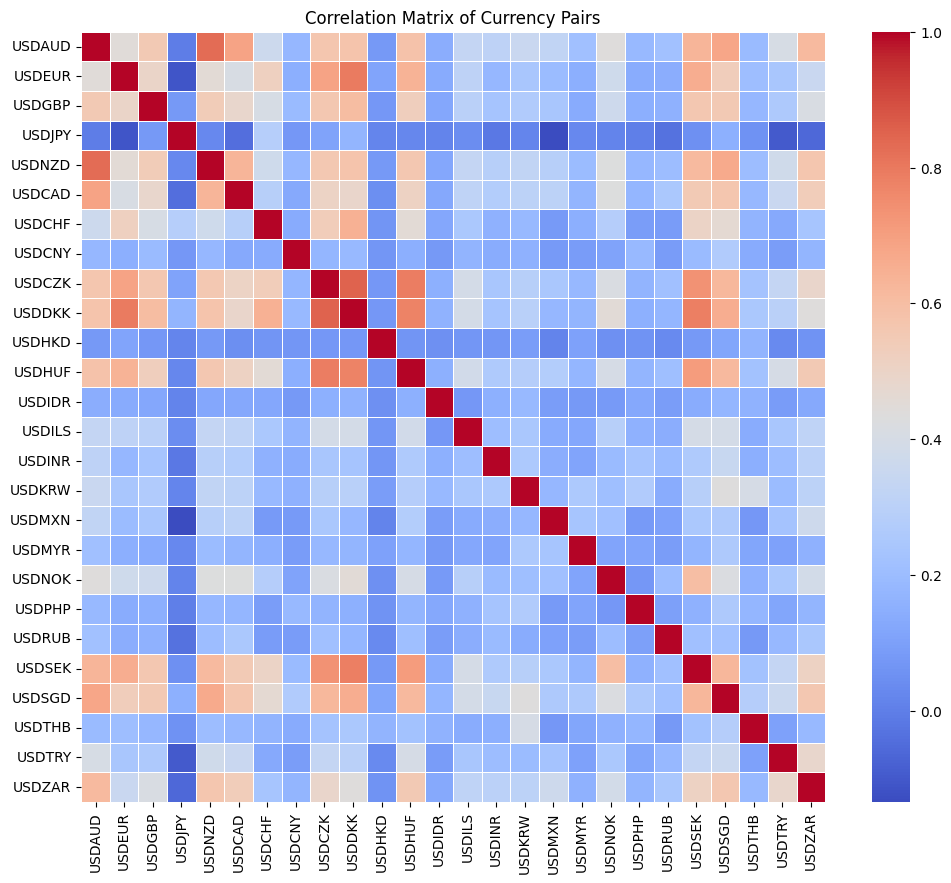

In [9]:
# Correlation analysis
log_returns_corr = log_returns_data.drop(columns=['Date']).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(log_returns_corr, annot=False, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Matrix of Currency Pairs")
plt.show()

# Time Series Analysis

This involves examining the data for trends, seasonality, and other temporal patterns. Given the nature of financial data, such as currency returns, this can be particularly insightful. We'll look at:

1. Trend Analysis: Identifying long-term movements in the data.
2. Seasonality Analysis: Checking for repeating patterns or cycles at regular intervals.
3. Volatility Clustering: Observing periods with high fluctuations and periods with relative calm.

## 1. Trend Analysis

We'll plot the cumulative sum of the log returns for each currency pair to observe any long-term trends in the data.

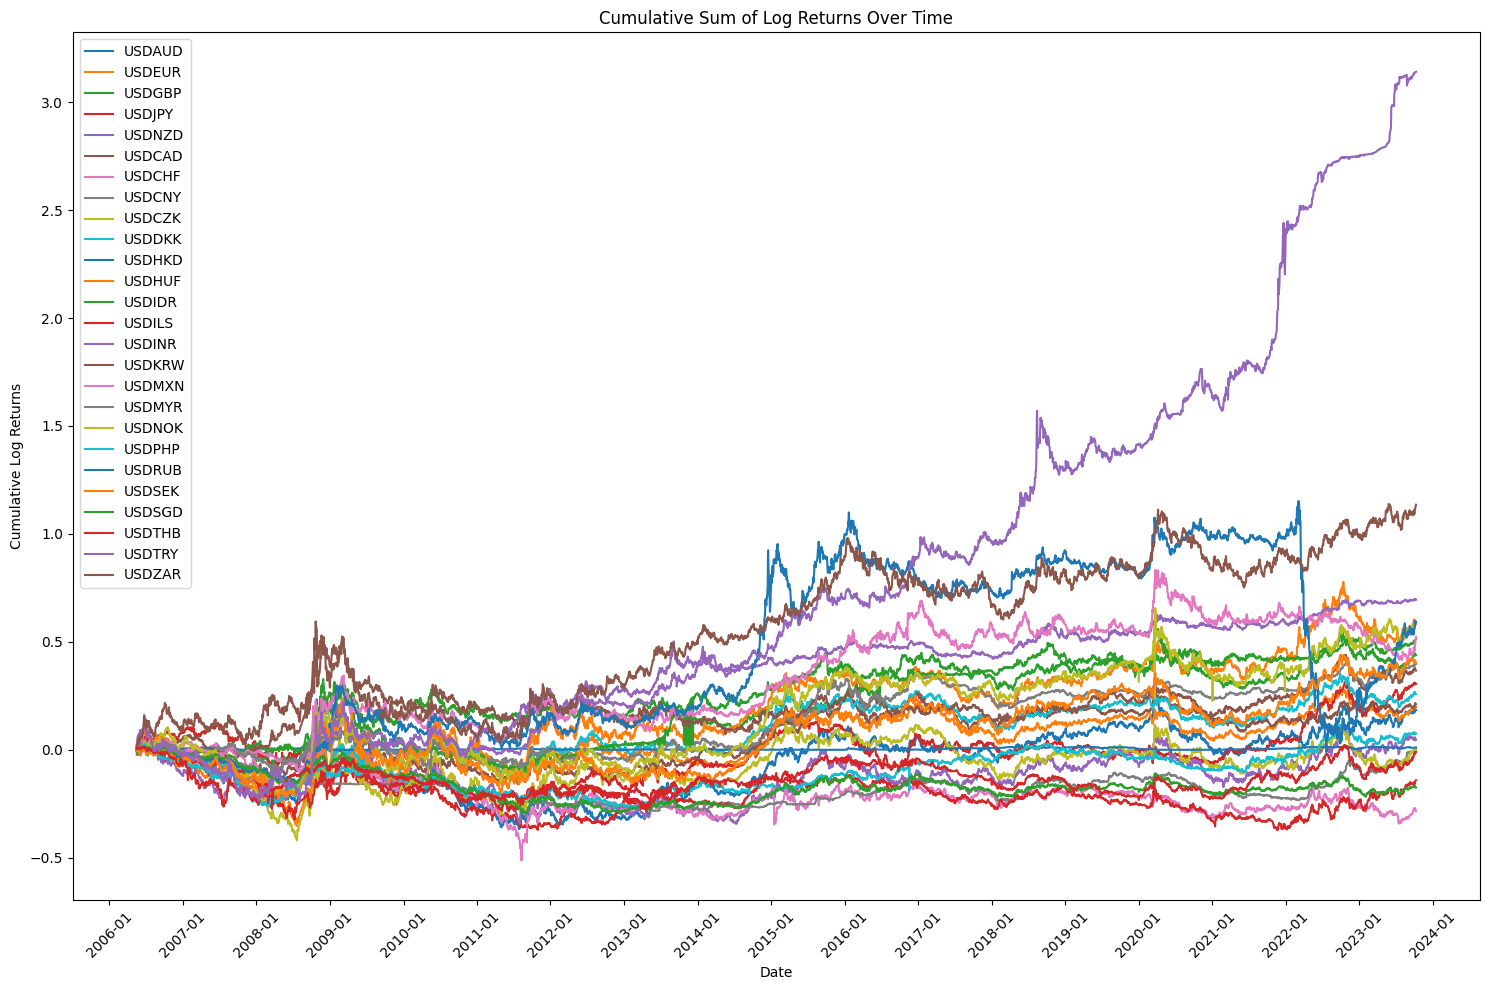

In [10]:
# Convert the 'Date' column to datetime and sort the data
log_returns_data['Date'] = pd.to_datetime(log_returns_data['Date'])

# Cumulative log returns
log_returns_cumsum = log_returns_data.drop(columns=['Date']).cumsum()
plot_cumulative_log_returns(log_returns_data, log_returns_cumsum, 'Cumulative Sum of Log Returns Over Time')

- Some currency pairs show a long-term upward trend, indicating a general increase in their value against the USD over time.
- There are periods of increased volatility where the cumulative returns fluctuate more dramatically.
- The plot reveals that not all currency pairs behave similarly, with some showing more stability and others exhibiting more significant changes.

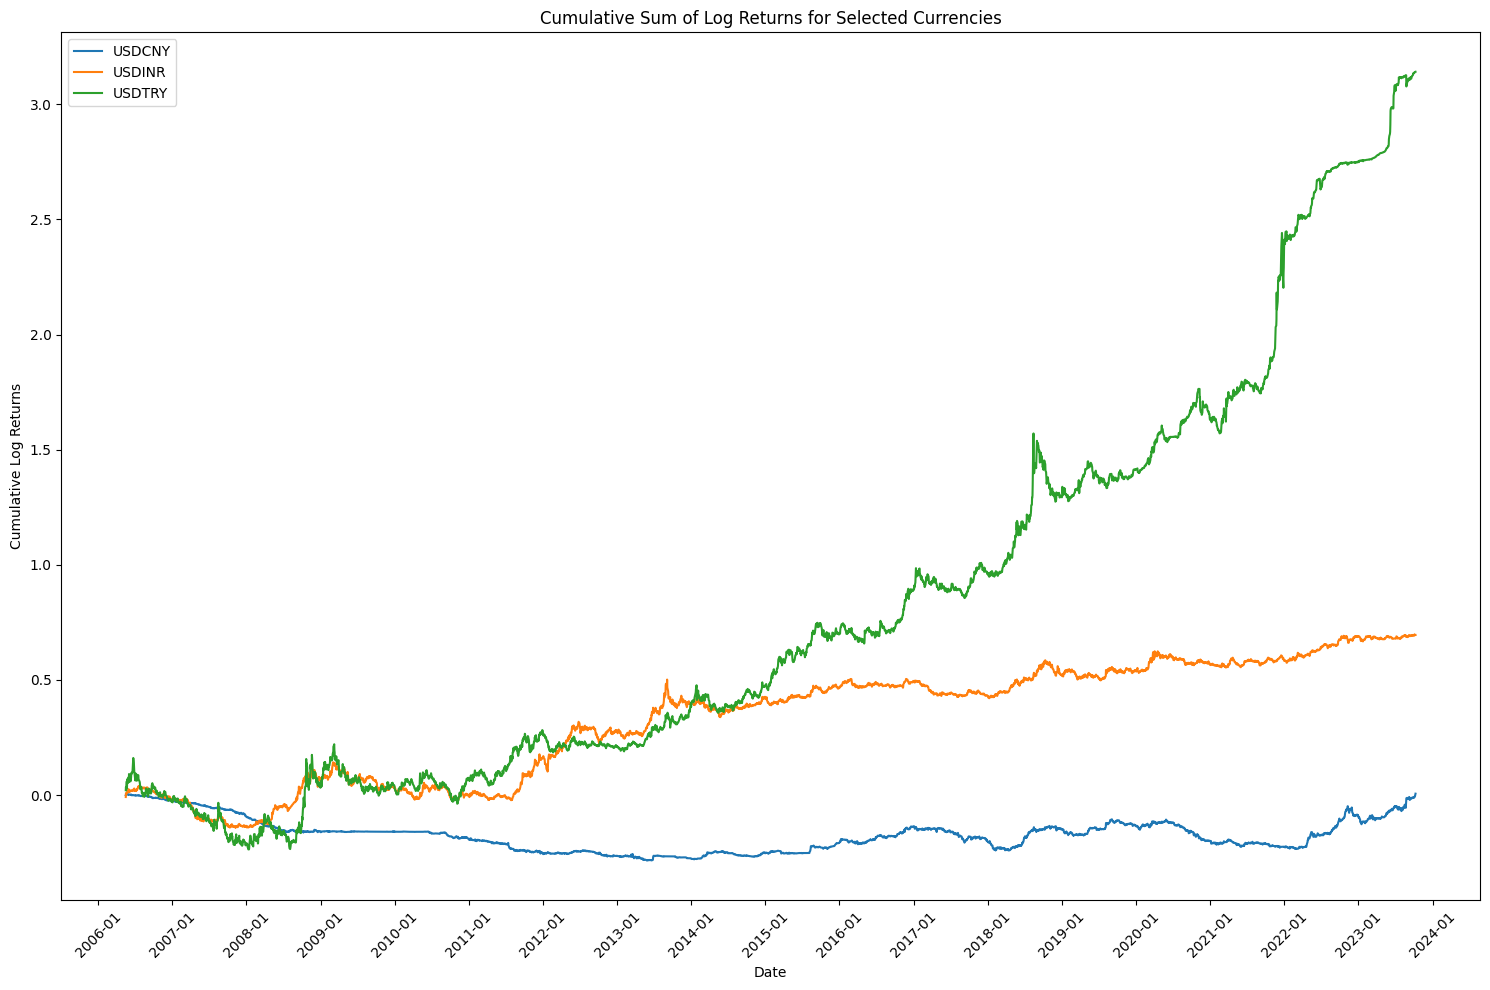

In [11]:
# Selected currency pairs
selected_currencies = ['USDCNY', 'USDINR', 'USDTRY']
plot_cumulative_log_returns(log_returns_data, log_returns_cumsum, 'Cumulative Sum of Log Returns for Selected Currencies', selected_currencies)

## 2. Seasonality Analysis

I will use the seasonal_decompose function from the statsmodels library, which requires specifying the frequency of the seasonality. In financial data, seasonality can sometimes be observed on a quarterly basis (every 3 months), but it may not be present or may vary depending on the currency pair.

The number 252 is often used in financial time series analysis because it represents the approximate number of trading days in a year. This is based on the typical number of weekdays in a year, minus the number of public holidays that markets are closed. It's a standard figure used for estimating the number of days markets are active and is particularly useful for converting daily data to an annual scale.

This figure is relevant when performing analyses that require understanding the data on an annual basis, such as annual volatility or when looking for seasonal patterns that might occur on an annual cycle.

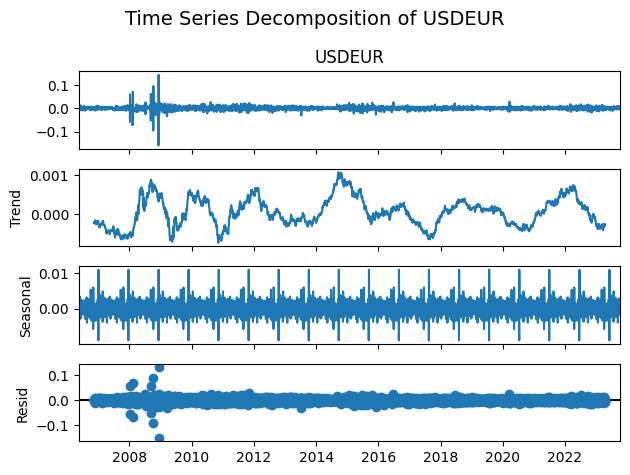

In [12]:
# Decompose and plot a currency pair
currency_pair = 'USDEUR'
decompose_and_plot(log_returns_data.set_index('Date'), currency_pair)

1. Observed: This is the actual log returns data that has been plotted.
2. Trend: This shows the long-term movement in the data, smoothing out short-term fluctuations.
3. Seasonal: This component captures the regular pattern within a year that repeats itself.
4. Residual: These are the irregularities in the data that cannot be explained by the trend or seasonal components.

For the USDEUR pair, 
- Trend Component: The trend line fluctuates around zero without a clear long-term upward or downward direction. This suggests that over the period under analysis, the 'USDEUR' currency pair does not exhibit a strong long-term trend in either direction.
- Seasonal Component: The seasonal plot shows some periodicity, but the fluctuations are very tight around the zero line, suggesting that any seasonality in the data is quite weak.
- Residuals: The residuals, which represent the noise or unexplained variation after the trend and seasonal components have been removed, show some periods of higher volatility. The clustering of extreme points (dots far from the zero line) indicates moments when the actual returns deviated significantly from the trend and seasonal patterns. These could correspond to unexpected market events or shocks.

## 3. Volatility Clustering

I will focus on examining the variability of the log returns for each currency pair. Volatility in financial markets is a measure of the degree of variation of a trading price series over time. It's commonly quantified using the standard deviation or variance of returns.

I already have standard deviation values from the descriptive statistics. However, for a more in-depth analysis, I can look at the rolling volatility over time. This involves calculating a moving standard deviation to see how volatility changes.

I'll plot the rolling volatility (using a 30-day window as an example). This will give us insights into how the volatility of these currency pairs has evolved over the dataset's time frame. 

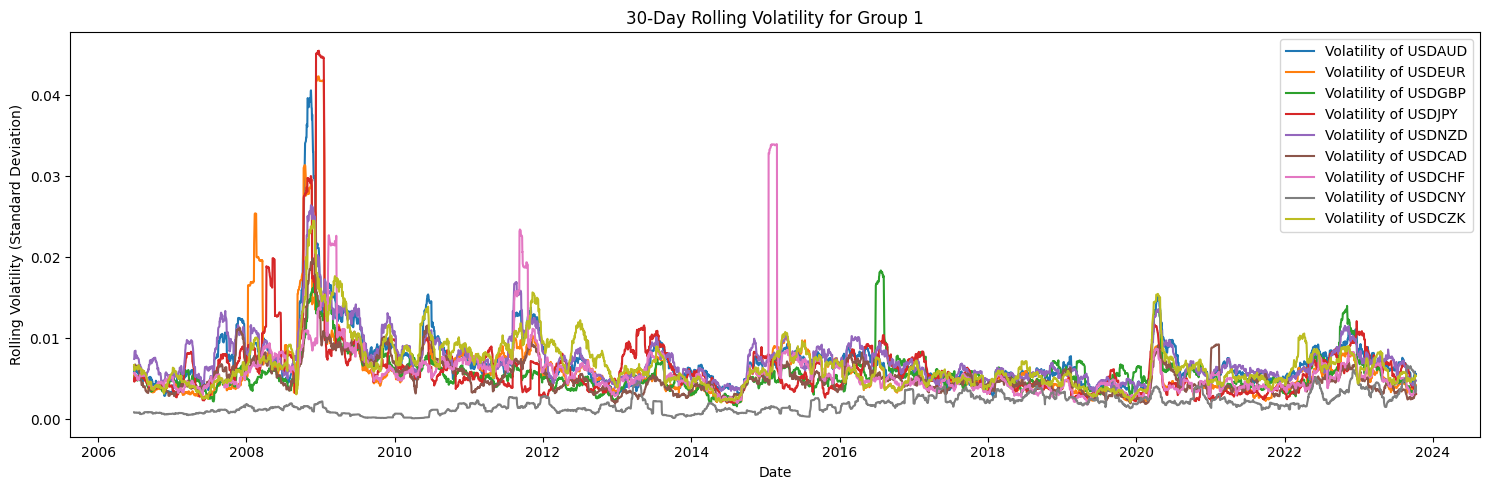

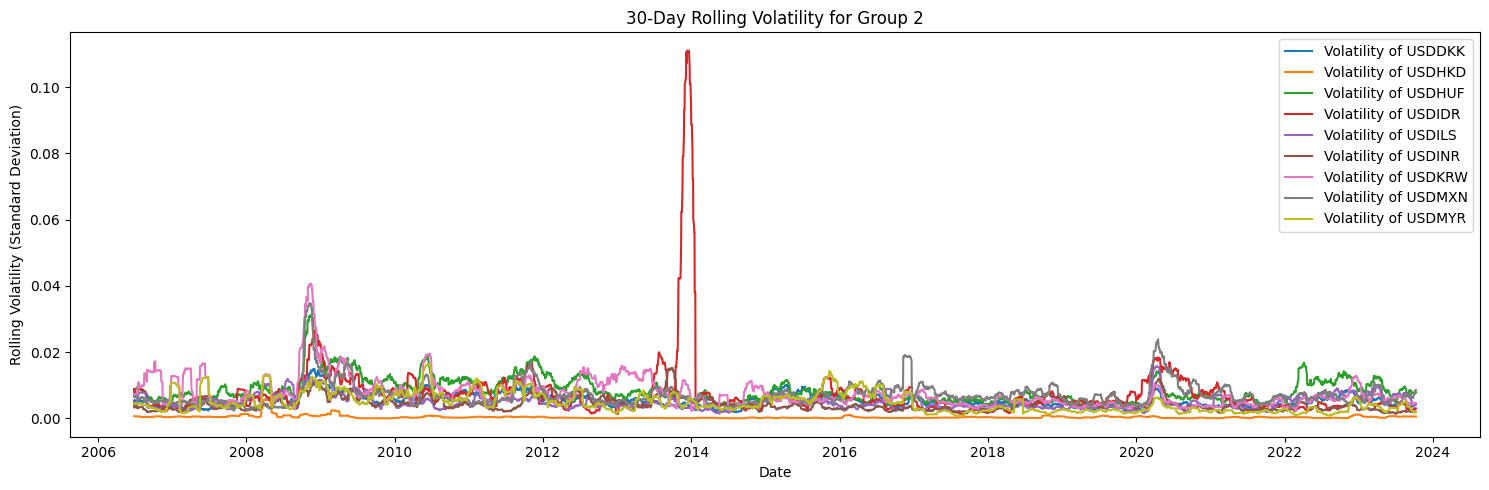

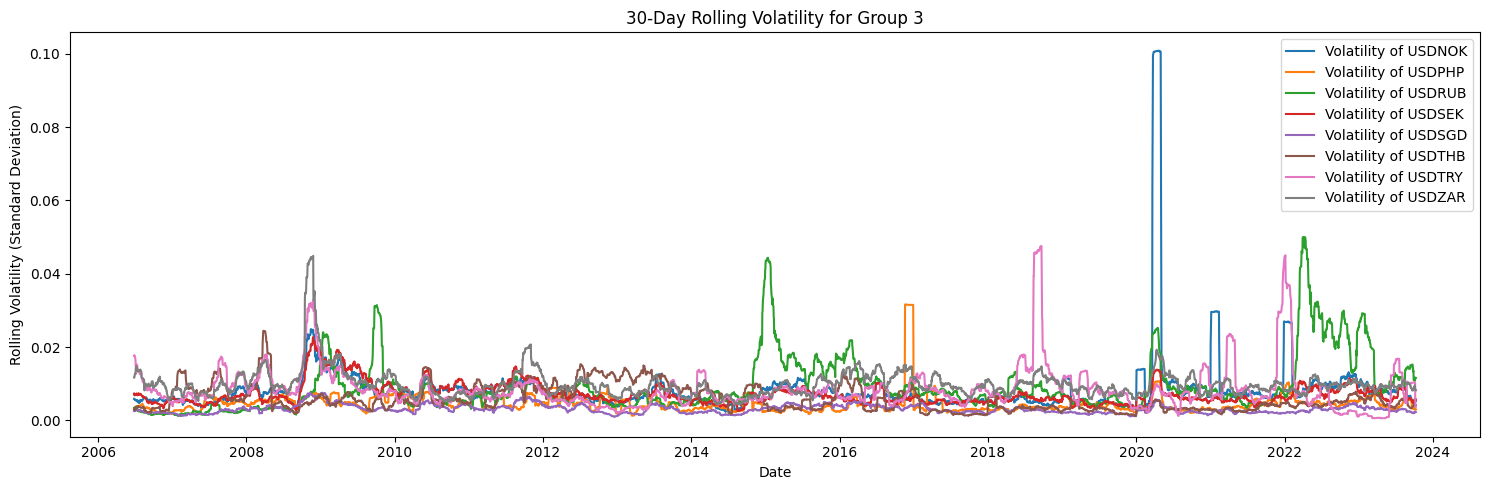

In [13]:
# Rolling volatility
rolling_window = 30
currencies = log_returns_data.columns[1:]  # Excluding 'Date'
group_1, group_2, group_3 = np.array_split(currencies, 3)
plot_rolling_volatility(log_returns_data, group_1, rolling_window, 1)
plot_rolling_volatility(log_returns_data, group_2, rolling_window, 2)
plot_rolling_volatility(log_returns_data, group_3, rolling_window, 3)

# Distribution Analysis

I will focus on understanding how the log returns of each currency pair are distributed. I can conduct normality tests, such as the Shapiro-Wilk test, to statistically assess whether the data follow a normal distribution. Additionally, I can plot histograms and Q-Q (quantile-quantile) plots for a visual assessment of normality.

In [14]:
# Normality test
normality_test_results = {currency: shapiro(log_returns_data[currency]) for currency in log_returns_data.columns[1:]}
normality_test_df = pd.DataFrame.from_dict(normality_test_results, orient='index', columns=['Statistic', 'p-value'])
normality_test_df

,Statistic,p-value
USDAUD,0.913432,4.203895e-45
USDEUR,0.745715,0.000000e+00
USDGBP,0.944046,2.001685e-38
USDJPY,0.754909,0.000000e+00
USDNZD,0.967466,7.361437e-31
USDCAD,0.963041,1.464408e-32
USDCHF,0.801876,0.000000e+00
USDCNY,0.876693,0.000000e+00
USDCZK,0.958951,5.365681e-34
USDDKK,0.976818,1.426867e-26


The Shapiro-Wilk test tests the null hypothesis that the data is normally distributed. A p-value less than the chosen alpha level (commonly 0.05) suggests that we reject the null hypothesis, indicating the data is not normally distributed.

Rejecting the null hypothesis in the context of a statistical test, like the Shapiro-Wilk test for normality, has specific implications based on the nature of the hypothesis being tested.

In statistical hypothesis testing, there are typically two hypotheses:

1. Null Hypothesis (H0): This is a statement of 'no effect' or 'no difference.' It's the hypothesis that the test aims to examine. In the case of the Shapiro-Wilk test, the null hypothesis is that the data follows a normal distribution.
2. Alternative Hypothesis (H1 or Ha): This is the hypothesis that there is an effect or a difference. In this case, the alternative hypothesis would be that the data does not follow a normal distribution.
When I perform a test like the Shapiro-Wilk test, I calculate a p-value, which is the probability of observing my data, or something more extreme, assuming the null hypothesis is true.

If this p-value is below a certain threshold (commonly 0.05), I reject the null hypothesis. This means that the evidence in my data is strong enough to conclude that the data does not follow a normal distribution.
If the p-value is above the threshold, I do not reject the null hypothesis. This doesn't necessarily prove the null hypothesis is true, but rather that there isn't enough evidence to conclude otherwise.
In the analysis I performed, since the p-values for the Shapiro-Wilk test were effectively zero (or very close to it) for all the currency pairs, I rejected the null hypothesis. This means I concluded that the log returns for these currency pairs do not follow a normal distribution, based on the data I analysed.

To supplement these statistical test results, I can also visually assess the distribution of these returns using histograms and Q-Q plots. 

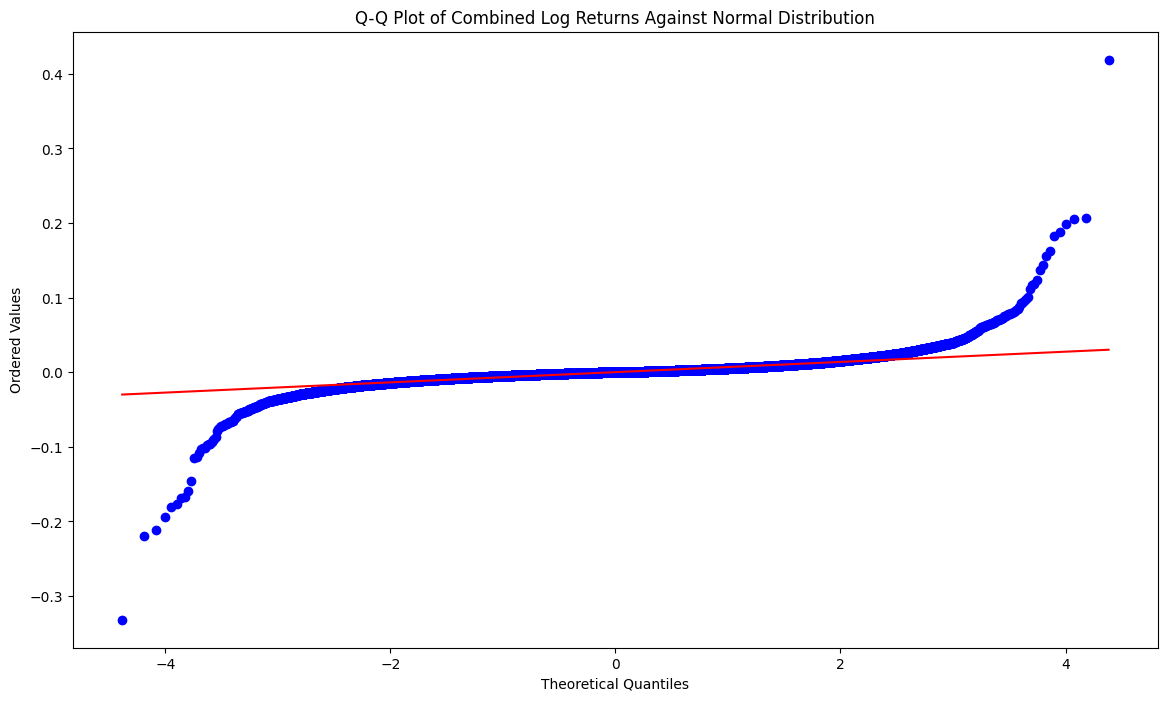

In [15]:
# Aggregated log returns
all_log_returns = log_returns_data.drop(columns='Date').values.flatten()

# Q-Q plot
plt.figure(figsize=(14, 8))
stats.probplot(all_log_returns, dist="norm", plot=plt)
plt.title('Q-Q Plot of Combined Log Returns Against Normal Distribution')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.show()

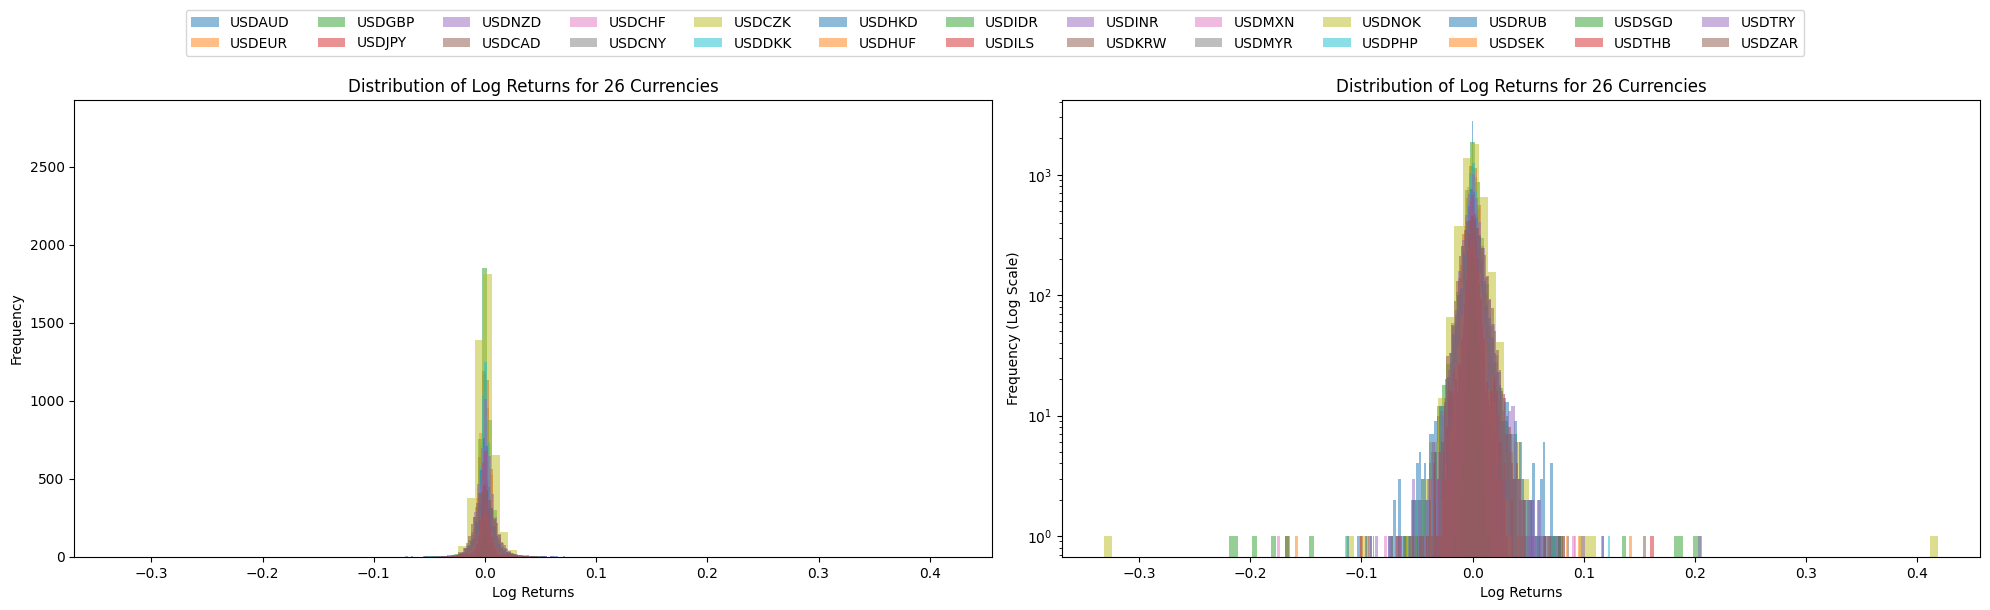

In [16]:
plot_histograms_side_by_side(log_returns_data, log_returns_data.columns[1:], bins=100)

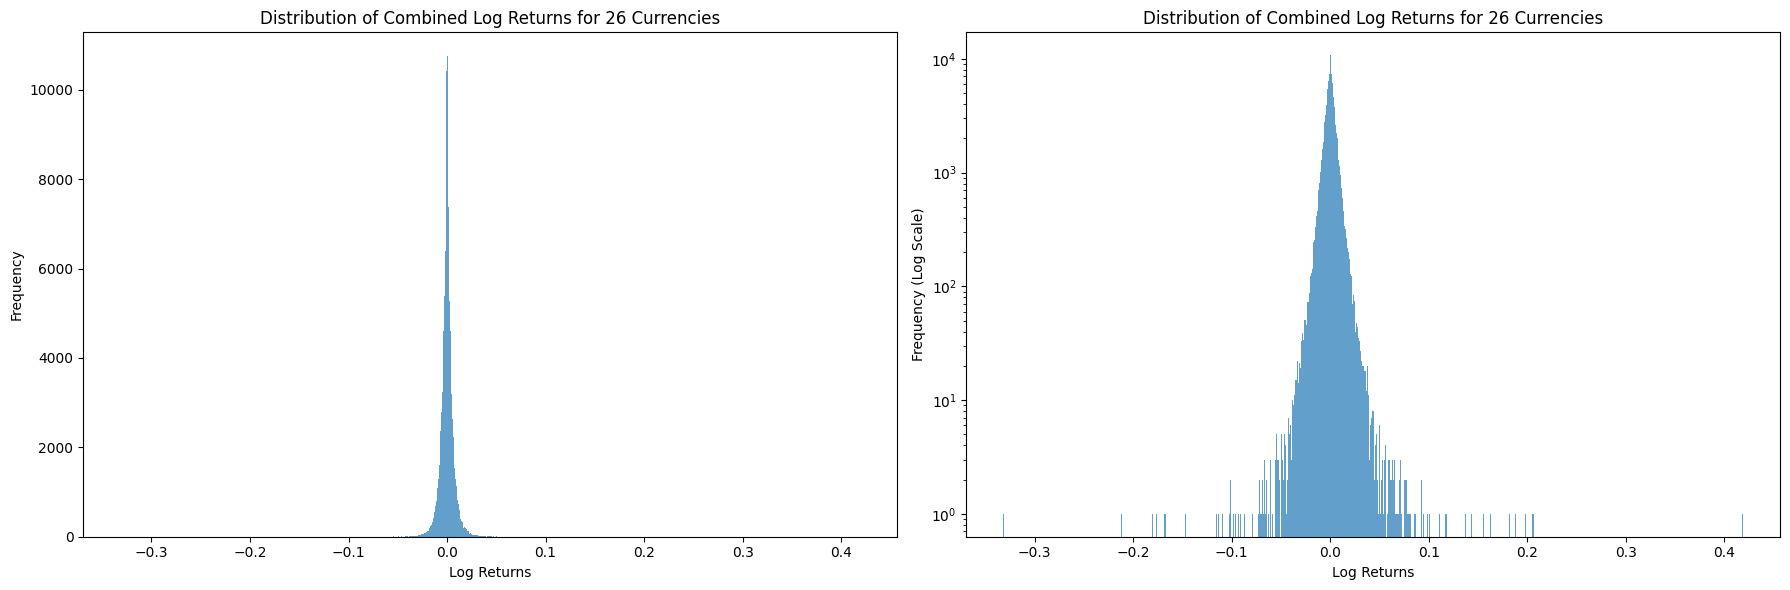

In [17]:
max_frequency = plot_combined_histogram_side_by_side(all_log_returns, bins=1000)

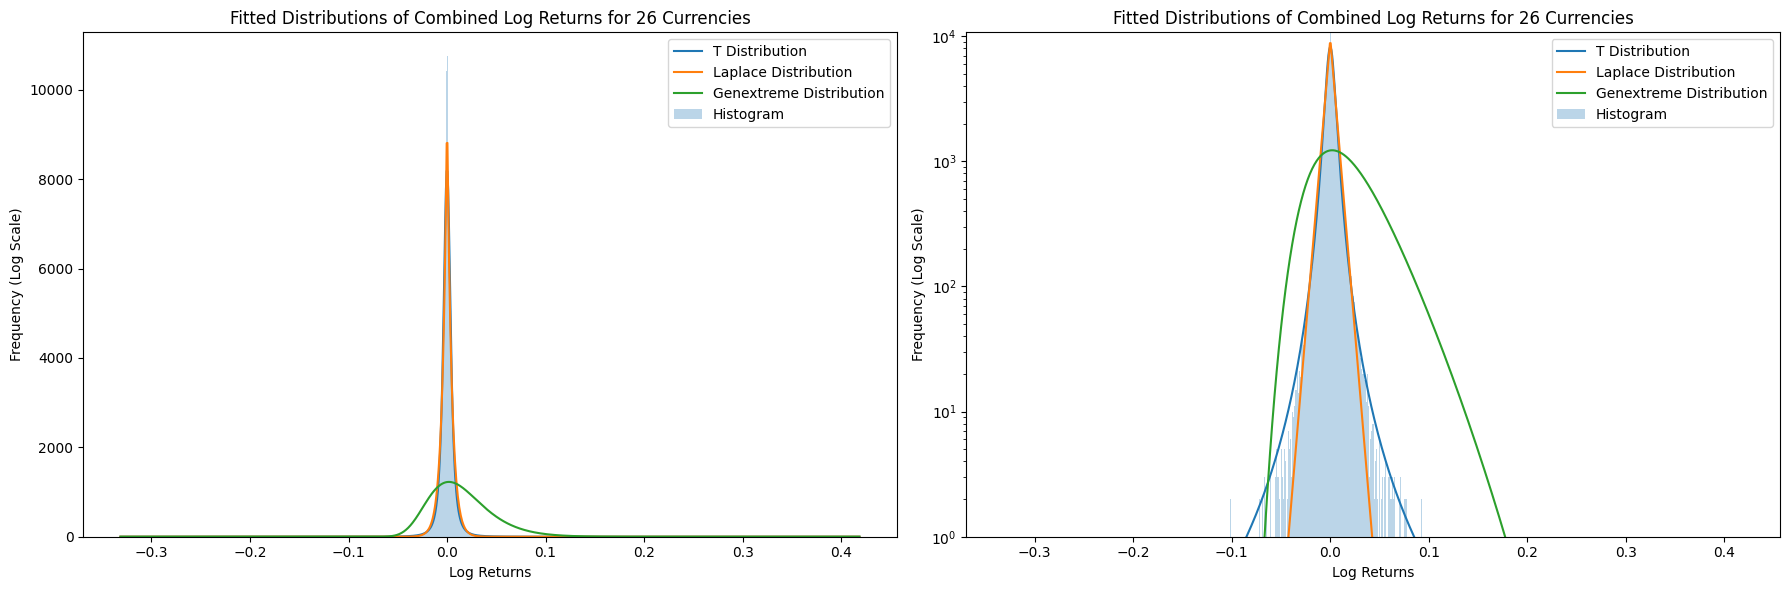

,Distribution,KS Statistic,P-Value,Parameters
0,t,0.021480,1.008186e-47,"(2.397135252269416, -1.6997589907443498e-05, 0..."
1,laplace,0.016743,3.688678e-29,"(2.733669851484599e-06, 0.0046368283227324605)"
2,genextreme,0.440571,0.000000e+00,"(0.06352785101623155, 0.00014941849690191188, ..."


In [18]:
# Fitting distributions and compiling results
distributions = [t, laplace, genextreme]
distribution_names = ["t", "laplace", "genextreme"]
fit_results_df = fit_and_plot_distributions_side_by_side(all_log_returns, distributions, distribution_names, bins=1000, max_frequency=max_frequency)
fit_results_df

## Distribution Fitting Results Analysis

The log returns data for a set of currency pairs were fitted to three different distributions: 
Student's t-distribution, Laplace distribution, and Generalized Extreme Value distribution. 
The goodness of fit for each distribution was evaluated using the Kolmogorov-Smirnov (K-S) test.

### Results Summary

#### Student's t-Distribution
- **KS Statistic:** 0.0215
- **P-Value:** 1.01e-47
- **Parameters:** Degrees of freedom ≈ 2.40, Location ≈ -1.70e-05, Scale ≈ 0.0046

#### Laplace Distribution
- **KS Statistic:** 0.0167
- **P-Value:** 3.69e-29
- **Parameters:** Mean ≈ 2.73e-06, Scale ≈ 0.0046

#### Generalized Extreme Value Distribution
- **KS Statistic:** 0.4406
- **P-Value:** 0.0
- **Parameters:** Shape ≈ 0.0635, Location ≈ 0.000149, Scale ≈ 0.0047

#### Interpretation
- The **KS Statistic** measures the difference between the empirical distribution of the data and the fitted distribution. A smaller KS statistic indicates a better fit.
- The **P-Value** tests the hypothesis that the data follow the specified distribution. A lower P-Value suggests that we can reject the hypothesis that the data follow the distribution.
- Based on these results, the **Laplace distribution** has the lowest KS statistic, indicating it may be the best fit among the three.
- The **Student's t-distribution** also shows a reasonably good fit, with a slightly higher KS statistic than the Laplace distribution.
- The **Generalized Extreme Value distribution** has a significantly higher KS statistic, indicating it is not as good a fit as the other two distributions for this data.

# Currency Interaction Strengths Geographical Distances

In [2]:
# Load J matrix from CSV
J_matrix_df = pd.read_csv('Results/J_matrix.csv')
J_matrix = J_matrix_df.to_numpy()

# Extract upper triangular part, excluding the diagonal
J_upper_triangular = np.triu(J_matrix, k=1)

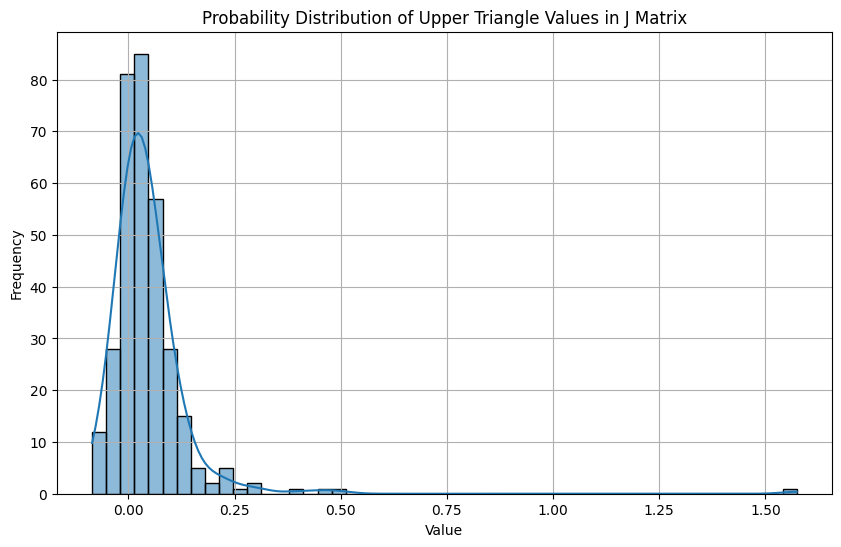

In [12]:
# Extracting the upper triangle of the matrix, excluding the diagonal
upper_triangle_values = J_matrix_df.where(np.triu(np.ones(J_matrix_df.shape), k=1).astype(bool)).stack()

# Plotting the histogram for the upper triangle values
plt.figure(figsize=(10, 6))
sns.histplot(upper_triangle_values, bins=50, kde=True)
plt.title('Probability Distribution of Upper Triangle Values in J Matrix')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [13]:
currency_to_capital = {
    'AUD': ('Canberra', -35.28, 149.13),   # Australia
    'EUR': ('Brussels', 50.85, 4.35),      # Eurozone (using Brussels, Belgium)
    'GBP': ('London', 51.51, -0.13),       # United Kingdom
    'JPY': ('Tokyo', 35.68, 139.76),       # Japan
    'NZD': ('Wellington', -41.29, 174.78), # New Zealand
    'CAD': ('Ottawa', 45.42, -75.69),      # Canada
    'CHF': ('Bern', 46.95, 7.45),          # Switzerland
    'CNY': ('Beijing', 39.90, 116.41),     # China
    'CZK': ('Prague', 50.08, 14.42),       # Czech Republic
    'DKK': ('Copenhagen', 55.68, 12.57),   # Denmark
    'HKD': ('Hong Kong', 22.32, 114.17),   # Hong Kong
    'HUF': ('Budapest', 47.50, 19.04),     # Hungary
    'IDR': ('Jakarta', -6.21, 106.85),     # Indonesia
    'ILS': ('Jerusalem', 31.77, 35.22),    # Israel
    'INR': ('New Delhi', 28.61, 77.20),    # India
    'KRW': ('Seoul', 37.57, 126.98),       # South Korea
    'MXN': ('Mexico City', 19.43, -99.13), # Mexico
    'MYR': ('Kuala Lumpur', 3.14, 101.69), # Malaysia
    'NOK': ('Oslo', 59.91, 10.75),         # Norway
    'PHP': ('Manila', 14.60, 120.98),      # Philippines
    'RUB': ('Moscow', 55.76, 37.62),       # Russia
    'SEK': ('Stockholm', 59.33, 18.07),    # Sweden
    'SGD': ('Singapore', 1.35, 103.82),    # Singapore
    'THB': ('Bangkok', 13.76, 100.50),     # Thailand
    'TRY': ('Ankara', 39.93, 32.85),       # Turkey
    'ZAR': ('Pretoria', -25.75, 28.19)     # South Africa
}

In [14]:
from math import radians, cos, sin, asin, sqrt

def haversine(coord1, coord2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1 = map(radians, coord1)
    lat2, lon2 = map(radians, coord2)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Example usage
distance_km = haversine(currency_to_capital['AUD'][1:], currency_to_capital['GBP'][1:])
print(f"Distance between Canberra and London: {distance_km} km")

Distance between Canberra and London: 16981.465653360876 km


In [16]:
from scipy.stats import pearsonr

def get_currency_code(currency_pair):
    """Extract currency codes from the currency pair, excluding 'USD'."""
    if currency_pair.startswith("USD"):
        return currency_pair[3:]
    else:
        return currency_pair[:3]

# Then, update the correlation analysis loop
distances = []
J_values = []

for i in range(J_upper_triangular.shape[0]):
    for j in range(i + 1, J_upper_triangular.shape[1]):
        if J_upper_triangular[i, j] != 0:
            # Extract currency codes
            currency1, currency2 = get_currency_code(J_matrix_df.columns[i]), get_currency_code(J_matrix_df.columns[j])

            # Skip if 'USD' is part of the pair
            if currency1 == 'USD' or currency2 == 'USD':
                continue

            # Calculate geographical distance
            coord1, coord2 = currency_to_capital[currency1][1:], currency_to_capital[currency2][1:]
            distance = haversine(coord1, coord2)
            distances.append(distance)

            # Store the corresponding J value
            J_values.append(J_upper_triangular[i, j])

# Convert lists to NumPy arrays for correlation calculation
distances = np.array(distances)
J_values = np.array(J_values)

# Compute Pearson correlation coefficient
correlation, p_value = pearsonr(distances, J_values)

print(f"Correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Correlation coefficient: -0.23530537831405346
P-value: 1.8190720430555043e-05


The correlation coefficient and p-value obtained suggest a moderate negative correlation between the interaction strengths and the geographical distances, which is statistically significant.

This code below will plot each currency pair's J value against its corresponding geographical distance. The red dashed line is a simple linear regression line, which helps visualise the overall trend in the data.

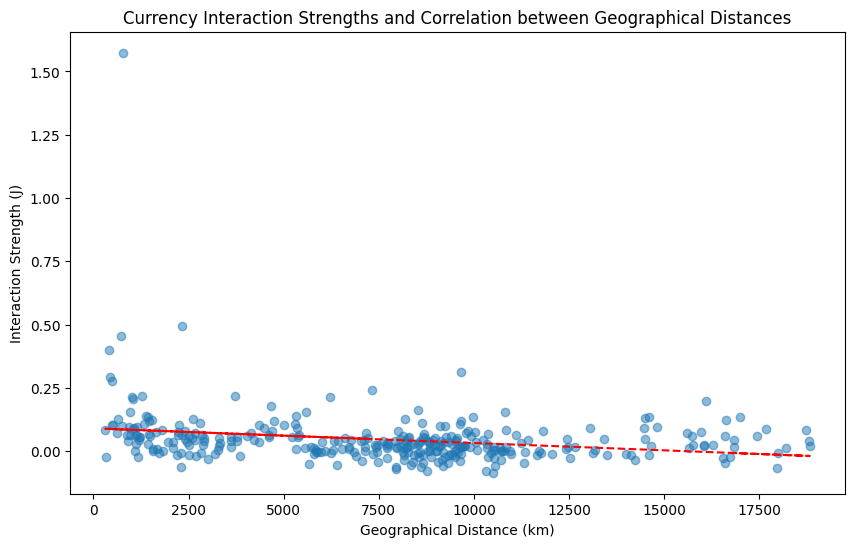

In [17]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(distances, J_values, alpha=0.5)

# Adding a title and labels
plt.title('Currency Interaction Strengths and Correlation between Geographical Distances')
plt.xlabel('Geographical Distance (km)')
plt.ylabel('Interaction Strength (J)')

# Optional: Fit and plot a regression line
z = np.polyfit(distances, J_values, 1)
p = np.poly1d(z)
plt.plot(distances, p(distances), "r--")

# Show the plot
plt.show()

In [18]:
# 'J_values' is the array with J interaction strengths and 'distances' is the array with corresponding geographical distances
max_J_value = np.max(J_values)
max_J_index = np.argmax(J_values)

# Assuming 'J_matrix_df' is the DataFrame of the J matrix with proper column labels
currency_pairs = [(J_matrix_df.columns[i], J_matrix_df.columns[j])
                  for i in range(J_upper_triangular.shape[0])
                  for j in range(i + 1, J_upper_triangular.shape[1])
                  if J_upper_triangular[i, j] != 0]

# The currency pair corresponding to the max J value
outlier_pair = currency_pairs[max_J_index]
print(f"The currency pair with the interaction strength above 1.5 is: {outlier_pair}")

The currency pair with the interaction strength above 1.5 is: ('EURUSD', 'DKKUSD')


# Network Analysis

1. Australia-United States Free Trade Agreement (AUSFTA)
- USDAUD

2. European Union (EU)
- USDEUR
- USDDKK (Denmark is in the EU but does not use the Euro)
- USDSEK (Sweden is in the EU but does not use the Euro)
- USDCZK (Czech Republic is in the EU but does not use the Euro)
- USDHUF (Hungary is in the EU but does not use the Euro)

3. North American Free Trade Agreement (NAFTA) / United States-Mexico-Canada Agreement (USMCA)
- USDCAD
- USDMXN

4. ASEAN (Association of Southeast Asian Nations)
- USDMYR (Malaysia)
- USDPHP (Philippines)
- USDSGD (Singapore)
- USDTHB (Thailand)

5. Other (No specific free trade agreement or economic union directly relevant)
- USDGBP (UK, post-Brexit)
- USDJPY (Japan)
- USDNZD (New Zealand, although part of AANZFTA, its primary relation to USD isn't defined by this)
- USDCHF (Switzerland)
- USDCNY (China)
- USDIDR (Indonesia)
- USDILS (Israel)
- USDINR (India)
- USDKRW (South Korea)
- USDNOK (Norway, not part of the EU)
- USDRUB (Russia)
- USDTRY (Turkey)
- USDZAR (South Africa)

In [36]:
# Before we proceed, let's define some general free trade areas and classify the currencies.
# We'll use a simplified classification based on common knowledge.

j_matrix_df = J_matrix_df.copy()

# Define free trade areas
free_trade_areas = {
    'NAFTA': ['USDCAD', 'USDMXN'],  # North American Free Trade Agreement: CAD, MXN
    'EU': ['USDEUR', 'USDDKK', 'USDCZK', 'USDSEK', 'USDNOK'],  # European Union: EUR, DKK, CZK, SEK, NOK
    'ASEAN': ['USDSGD', 'USDMYR', 'USDTHB', 'USDPHP'],  # Association of Southeast Asian Nations: SGD, MYR, THB, PHP
    'Others': ['USDAUD', 'USDGBP', 'USDJPY', 'USDNZD', 'USDCHF', 
               'USDCNY', 'USDRUB', 'USDTRY', 'USDZAR']  # Other major economies: AUD, GBP, JPY, NZD, CHF, CNY, RUB, TRY, ZAR
    # Note: This is a simplified classification and might not reflect current trade agreements accurately.
}

# Create a new column in the DataFrame for the free trade area classification
j_matrix_df['Free_Trade_Area'] = None

# Assign each currency to its free trade area
for area, currencies in free_trade_areas.items():
    j_matrix_df.loc[j_matrix_df.index.isin(currencies), 'Free_Trade_Area'] = area

# Check if the new column has been added successfully
j_matrix_df.head()


,USDAUD,USDEUR,USDGBP,USDJPY,USDNZD,USDCAD,USDCHF,USDCNY,USDCZK,USDDKK,...,USDMYR,USDNOK,USDPHP,USDRUB,USDSEK,USDSGD,USDTHB,USDTRY,USDZAR,Free_Trade_Area
0,0.000000,-0.023346,0.134738,0.017848,0.495155,0.197807,-0.045124,0.000678,0.021781,0.024032,...,0.007565,0.074545,0.005502,0.089473,0.071236,0.214277,0.023303,0.047055,0.155907,None
1,-0.023346,0.000000,-0.023332,-0.016615,0.083672,-0.050758,0.278150,-0.062174,0.454085,1.573762,...,0.045281,0.001845,-0.085365,0.101678,0.215869,-0.057637,0.098974,0.057665,0.033689,None
2,0.134738,-0.023332,0.000000,0.053607,0.039016,0.092498,0.099982,-0.002899,0.088044,0.153811,...,0.002550,0.097149,-0.000256,0.022503,0.029564,0.084904,0.043989,-0.007810,0.000329,None
3,0.017848,-0.016615,0.053607,0.000000,0.053824,-0.077905,0.311265,0.011274,0.020876,0.068859,...,0.009108,-0.042624,-0.032793,-0.043193,-0.036320,0.137634,0.062252,-0.077957,-0.013890,None
4,0.495155,0.083672,0.039016,0.053824,0.000000,0.129776,0.018606,0.001247,0.011703,-0.067318,...,0.001554,0.088391,0.019860,-0.028056,0.058607,0.163318,0.020584,0.042973,0.081036,None


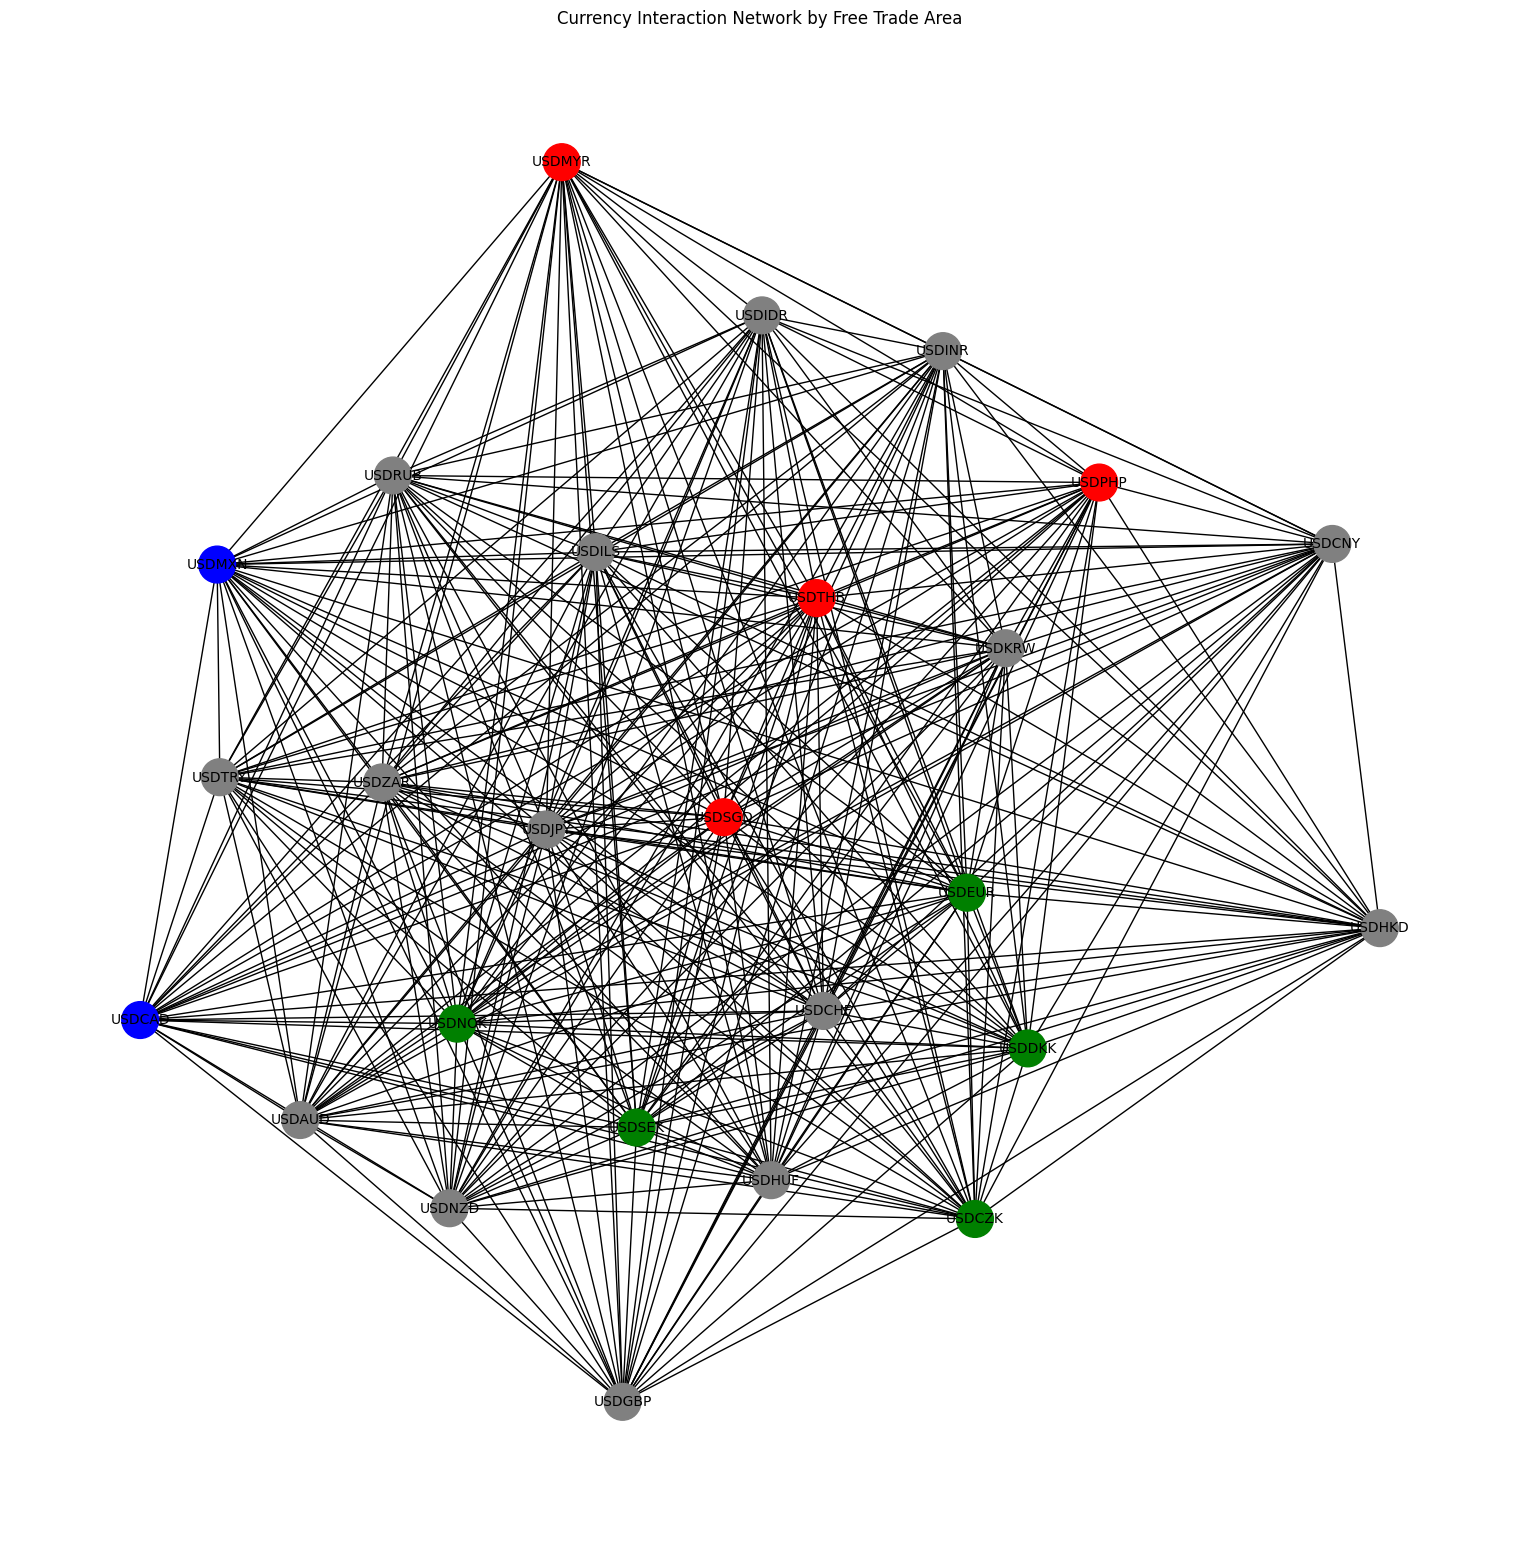

In [37]:
import networkx as nx
import matplotlib.pyplot as plt

# Correcting the classification by creating a dictionary mapping each currency to its free trade area
currency_to_area = {}
for area, currencies in free_trade_areas.items():
    for currency in currencies:
        currency_to_area[currency] = area

# Creating a list of nodes for the network graph, each node will have an attribute 'area' with its free trade area
nodes = []
for currency in j_matrix_df.columns:
    # Ignoring the last column which we previously tried to add
    if currency != 'Free_Trade_Area':
        nodes.append((currency, {'area': currency_to_area.get(currency, 'Others')}))

# Creating the network graph
G = nx.Graph()

# Adding nodes to the graph
G.add_nodes_from(nodes)

# Adding edges to the graph, only if interaction strength is not zero to avoid clutter
for i, currency1 in enumerate(j_matrix_df.columns[:-1]):  # Excluding the 'Free_Trade_Area' column
    for j, currency2 in enumerate(j_matrix_df.columns[:-1]):
        if i < j:  # To avoid duplicates as it's a symmetric matrix
            interaction_strength = j_matrix_df.iloc[i, j]
            if interaction_strength != 0:
                G.add_edge(currency1, currency2, weight=abs(interaction_strength))

# Applying a spring layout to visualize the graph
pos = nx.spring_layout(G, weight='weight', iterations=50)

# Assigning colors to each free trade area
area_colors = {
    'NAFTA': 'blue',
    'EU': 'green',
    'ASEAN': 'red',
    'Others': 'grey'  # Assigning a default color for currencies not belonging to the specified areas
}

# Update the node colors based on their free trade area
node_colors = [area_colors[data['area']] for _, data in G.nodes(data=True)]

# Drawing the graph
plt.figure(figsize=(15, 15))
nx.draw(G, pos, with_labels=True, node_size=700, node_color=node_colors, edge_color='black', linewidths=1, font_size=10)
plt.title('Currency Interaction Network by Free Trade Area')
plt.show()

In [56]:
import pandas as pd
import networkx as nx

# Load the CSV file into a DataFrame
J_matrix_df = pd.read_csv('Results/J_matrix.csv')
J_matrix_df.index = J_matrix_df.columns

# Create a graph from the adjacency matrix
G = nx.from_pandas_adjacency(J_matrix_df)  # Use absolute values of weights

# Compute betweenness centrality
bc = nx.betweenness_centrality(G, weight='weight')

# Find and print nodes with zero betweenness centrality
bc_nodes = {node: centrality for node, centrality in bc.items()}
print("Nodes with betweenness centrality:", bc_nodes)

Nodes with zero betweenness centrality: {'USDAUD': 0.15000000000000002, 'USDEUR': 0.7783333333333334, 'USDGBP': 0.03166666666666667, 'USDJPY': 0.8183333333333334, 'USDNZD': 0.38333333333333336, 'USDCAD': 0.09000000000000001, 'USDCHF': 0.8116666666666668, 'USDCNY': 0.6333333333333334, 'USDCZK': 0.315, 'USDDKK': 0.895, 'USDHKD': 0.395, 'USDHUF': 0.535, 'USDIDR': 0.335, 'USDILS': 0.42333333333333334, 'USDINR': 0.23833333333333334, 'USDKRW': 0.8550000000000001, 'USDMXN': 0.505, 'USDMYR': 0.24500000000000002, 'USDNOK': 0.3616666666666667, 'USDPHP': 0.795, 'USDRUB': 0.3716666666666667, 'USDSEK': 0.7133333333333334, 'USDSGD': 0.0, 'USDTHB': 0.4033333333333334, 'USDTRY': 0.7783333333333334, 'USDZAR': 0.795}
